In [1]:
from bson.son import SON
import json
from pymongo import MongoClient
from bson.objectid import ObjectId
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import matplotlib.colors as mc
import colorsys
from matplotlib import rcParams
import seaborn as sns
from datetime import datetime
from sshtunnel import SSHTunnelForwarder
import pymongo

# Connect to remote mongodb

In [2]:
with open('../keys.json') as k:
    keys = json.loads(k.read())
    MONGO_HOST = keys["SSH"]["MONGO_HOST"] # i.e. 10.9.13.14
    MONGO_DB = keys["SSH"]["MONGO_DB"] # i.e. dm_project 
    MONGO_USER = keys["SSH"]["MONGO_USER"] # i.e. studente
    MONGO_PASS = keys["SSH"]["MONGO_PASS"] # i.e. la password della vm

server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_password=MONGO_PASS,
    remote_bind_address=('127.0.0.1', 27017)
)

server.start() # remember to stop

client = pymongo.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port

db = client[MONGO_DB]

db.list_collection_names()

['system.indexes', 'twitch', 'twitter', 'vgchartz']

# Twitch

### Get  data 

In [3]:
pipelineh = [{"$unwind": "$data"},
            { "$group": {
                "_id": {"name": "$data.game_name",
                        "year" :  { "$substr" : ["$timestamp", 0, 4 ] }, 
                        "month" : { "$substr" : ["$timestamp", 5, 2 ] },     
                        "day" :   { "$substr" : ["$timestamp", 8, 2 ] },
                        "hour": { "$substr" : ["$timestamp", 11, 2 ] } },
                "avgViewers": { "$avg": '$data.viewers'}
            }},
            {"$sort": {"_id": 1} }]

In [4]:
# this is very slow
start = datetime.now()
resulth = list(db.twitch.aggregate(pipelineh, allowDiskUse = True))
end = datetime.now()
(end-start).total_seconds()

91.910977

In [5]:
dfh = json_normalize(resulth)
dfh = dfh.rename(index=str, columns={"_id.name": "name", "_id.hour": "hour",
                                  "_id.day": "day","_id.month": "month","_id.year": "year"})
dfh = dfh[['name','day', 'month', 'year', 'hour', 'avgViewers']]

In [6]:
dfh.head()

,name,day,month,year,hour,avgViewers
0,8 To Glory - The Official Game of the PBR,14,06,2019,18,1.000000
1,8 To Glory - The Official Game of the PBR,22,06,2019,05,5.000000
2,F1 2019,20,06,2019,17,10.000000
3,F1 2019,20,06,2019,18,24.842105
4,F1 2019,20,06,2019,19,29.250000


#### Add Hourly Top

In [7]:
dfh['hourly_top'] = dfh.sort_values(['day', 'month', 'year', 'hour', 'avgViewers'],
                               ascending=[True, True, True, True, False]).groupby(['day', 'month', 'year', 'hour']).cumcount()
dfh['hourly_top'] = dfh['hourly_top'] + 1

In [8]:
dfh.head()

,name,day,month,year,hour,avgViewers,hourly_top
0,8 To Glory - The Official Game of the PBR,14,06,2019,18,1.000000,2206
1,8 To Glory - The Official Game of the PBR,22,06,2019,05,5.000000,1250
2,F1 2019,20,06,2019,17,10.000000,1034
3,F1 2019,20,06,2019,18,24.842105,726
4,F1 2019,20,06,2019,19,29.250000,727


## Twitch Viz

In [9]:
def add_text_twitch(i):
    i = str(i)
    suff = 'th'
    if i[-1] == '1' and i[-2:] != '11':
        suff = 'st'
    if i[-1] == '2' and i[-2:] != '12':
        suff = 'nd'
    if i[-1] == '3' and i[-2:] != '13':
        suff = 'rd'
    suff = suff + ' most viewed'
    return(i+suff)

In [10]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [45]:
def plot_twitch(gns, df, how = 'hourly', text_coors = 'default', rad = 'default'):
    
    gns = sorted(gns) # necessary, otherwise some problem with colors
    
    if how == 'daily': 
        # calculate daily averages and top
        df = df[['name', 'day', 'month', 'year', 'hour', 'avgViewers']]
        df = df.groupby(['name', 'day', 'month', 'year'])['avgViewers'].mean().reset_index()
        df['daily_top'] = df.sort_values(['day', 'month', 'year', 'avgViewers'],
                               ascending=[True, True, True, False]).groupby(['day', 'month', 'year']).cumcount()
        df['daily_top'] = df['daily_top'] + 1
    
    # consider only the games that are specigied in gns
    df = df[df.name.isin(gns)].sort_values('avgViewers', ascending = False)
    
    # don't continue if the games in gns are spelled incorrectly, or do not exists
    if not all([elem in df['name'].unique() for elem in gns]):
        print("Error: at least one invalid game name")
        return None
    
    # choose date format
    if how == 'daily':
        df['date'] = df['day'] + '-' + df['month'] + '-' + df['year']
        df['date'] =  pd.to_datetime(df['date'], format='%d-%m-%Y')
    else:
        df['date'] = df['day'] + '-' + df['month'] + '-' + df['year'] + ' ' + df['hour']
        df['date'] =  pd.to_datetime(df['date'], format='%d-%m-%Y %H')
      
    # fill missing values between times
    if len(gns) == 1:
        df.index = df['date']
        if how == 'daily':
            df = df.resample('D', how='mean')
        else:
            df = df.resample('H', how='mean')
        df['date'] = df.index
        df.index = pd.RangeIndex(len(df.index))
        df['avgViewers'] = df['avgViewers'].fillna(0) # fill avgViewers NAs with 0
        
        # restore old index
        df.index = pd.RangeIndex(len(df.index))
        #df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
    
    sns.set_style("white")
    # rcParams['font.family'] = 'garamond'
    # rcParams['font.family'] = 'helvetica'
    rcParams['font.family'] = 'serif'
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    # plot different lines for different games, if more than one game is specified
    if len(gns) > 1:
        df.name = df.name.astype('category')
        ax = sns.lineplot(x="date", y="avgViewers", hue = 'name', data=df)
    else:
        ax = sns.lineplot(x="date", y="avgViewers", data=df)
        
    # Set title
    if len(gns) > 1:
        c = 'Twitch views: ' +  '{} vs. '*(len(gns)-1)  + '{}'
        ax.set_title(c.format(*gns), fontsize=18)
    else:
        ax.set_title("Average {} views of {} on Twitch".format(how, gns[0]), fontsize=18)
    
    ax.set_ylabel('', fontsize=1)
    ax.set_xlabel('', fontsize=1)
    
    # set tickz
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation = 45, fontsize = 13)
    plt.yticks(fontsize = 13)
    
    if len(gns) > 1:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
        plt.setp(ax.get_legend().get_texts(), fontsize='16')
    
    
    maxx = np.max(df['avgViewers'])
    text_vspace = maxx / 80
    top_string = how + '_top' # daily_top or hourly_top for column selection
    
    i = - len(gns)
    q = 0
    for gn in gns:
        if len(gns) > 1:
            ndf = df[df['name'] == gn]
        else:
            ndf = df

        top = np.argmin(ndf[top_string]) # index of best position reached by game
        
        og_col = ax.get_lines()[i].get_c()
        col = lighten_color(og_col, 1.4) # darker shade of colour for text
        
        x = mdates.date2num(df.date[top]) # convert date to value on x axis
        y = ndf.avgViewers[top]            # value on y axis
        xmed = np.median(mdates.date2num(df.date))
        ymed = maxx / 2
        
        if text_coors == 'default':
            if x < xmed:
                xtext = x + 1.5
            else:
                xtext = x - 1.5
            if y < ymed:
                ytext = y + maxx/5
            else:
                ytext = y - maxx/5
        else:
            xtext = x + text_coors[q][0]
            ytext = y + text_coors[q][1]
        
        if rad == 'default':
            rad = ['0.2']*len(gns)
        
        ax.annotate(add_text_twitch(int(df[top_string][top])),
                    xy=(x, y), #xycoords='data',
                    xytext = (xtext, ytext),
                    color = col, fontsize = 13,
                    arrowprops = dict(arrowstyle="->",
                                      color=og_col,
                                     connectionstyle="arc3, rad="+rad[q]))
        
        q += 1
        i += 1
        
        #x_text = x - 1
        #y_text = y + text_vspace + 500 
        
        # ax.text(x_text, y_text,
        #         add_text_twitch(int(df[top_string][top])),
        #         horizontalalignment='center', size='large', color = col, fontsize = 13)
        
        # plt.scatter(mdates.date2num(df.date[top]), df.avgViewers[top], marker='o', color = col,  s = 20)

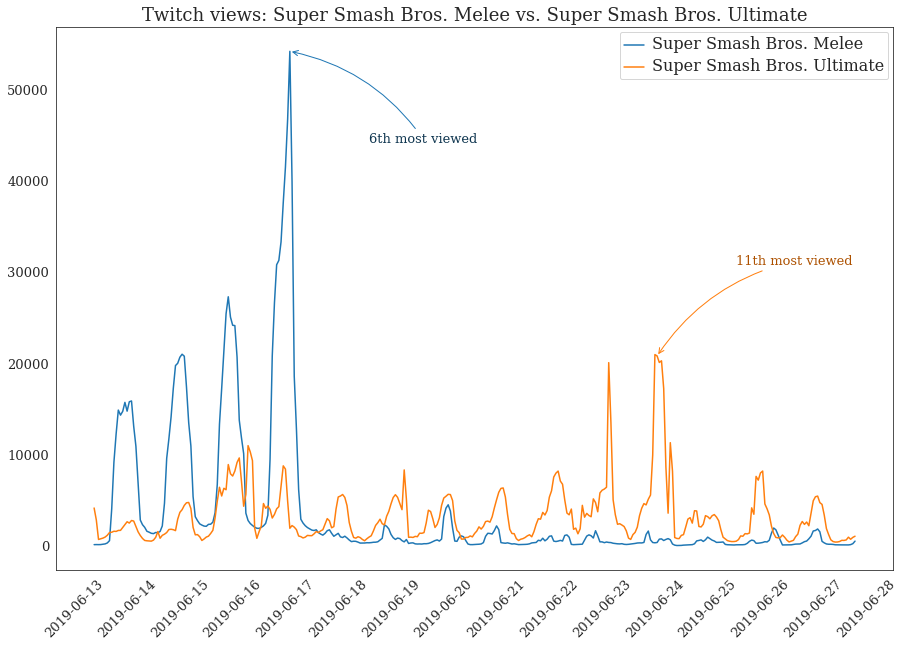

In [46]:
plot_twitch(["Super Smash Bros. Melee",  'Super Smash Bros. Ultimate'], dfh,
            how = 'hourly', text_coors = [[1.5, -10000], [1.5, 10000]], rad = ['0.2', '0.2'])

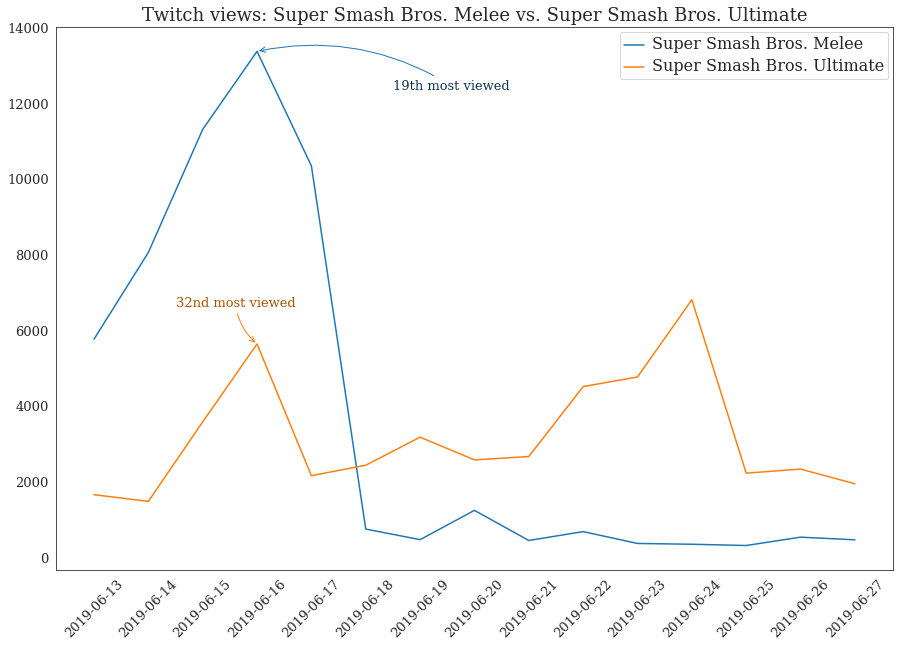

In [54]:
plot_twitch(["Super Smash Bros. Melee",  'Super Smash Bros. Ultimate'], dfh,
            how = 'daily', text_coors = [[2.5, -1000], [-1.5, 1000]], rad = ['0.2', '0.2'])

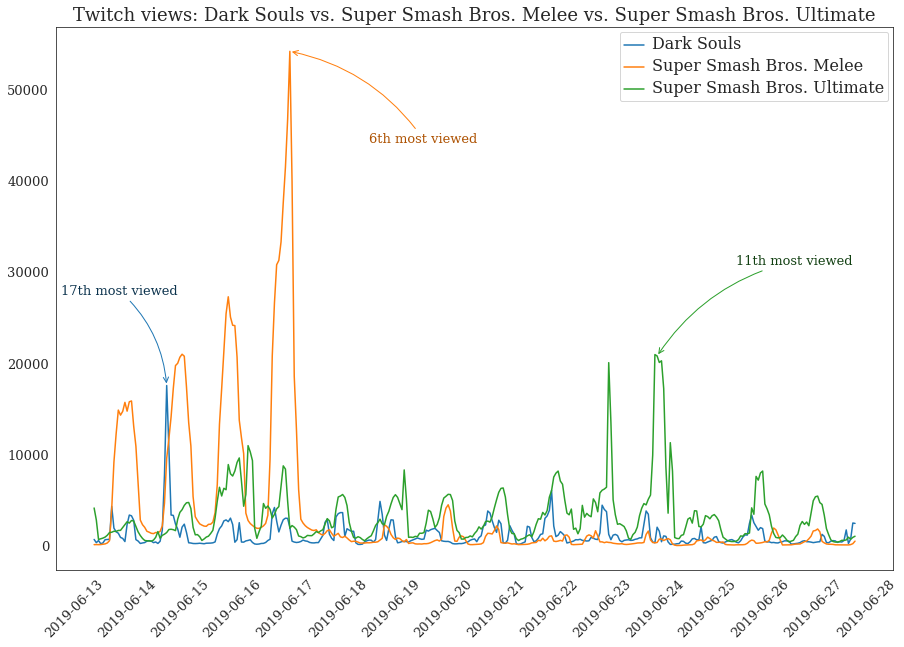

In [47]:
plot_twitch(['Dark Souls', "Super Smash Bros. Melee",  'Super Smash Bros. Ultimate'], dfh,
            how = 'hourly', text_coors = [[-2, +10000], [1.5, -10000], [1.5, 10000]], rad = ['-0.2', '0.2', '0.2'])

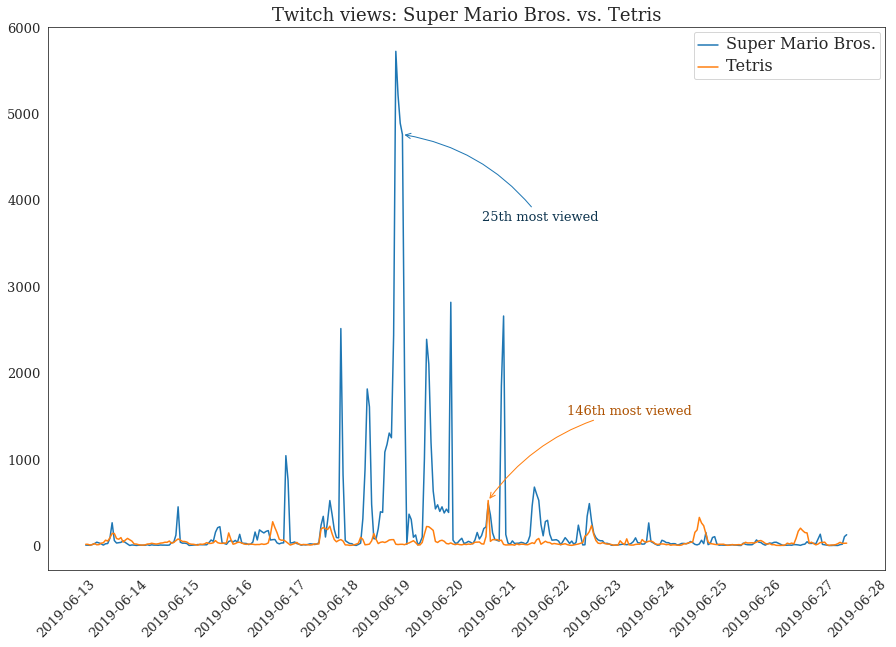

In [48]:
plot_twitch([ "Super Mario Bros.",  'Tetris'], dfh, how = 'hourly', text_coors = [[1.5, - 1000], [1.5, 1000]])

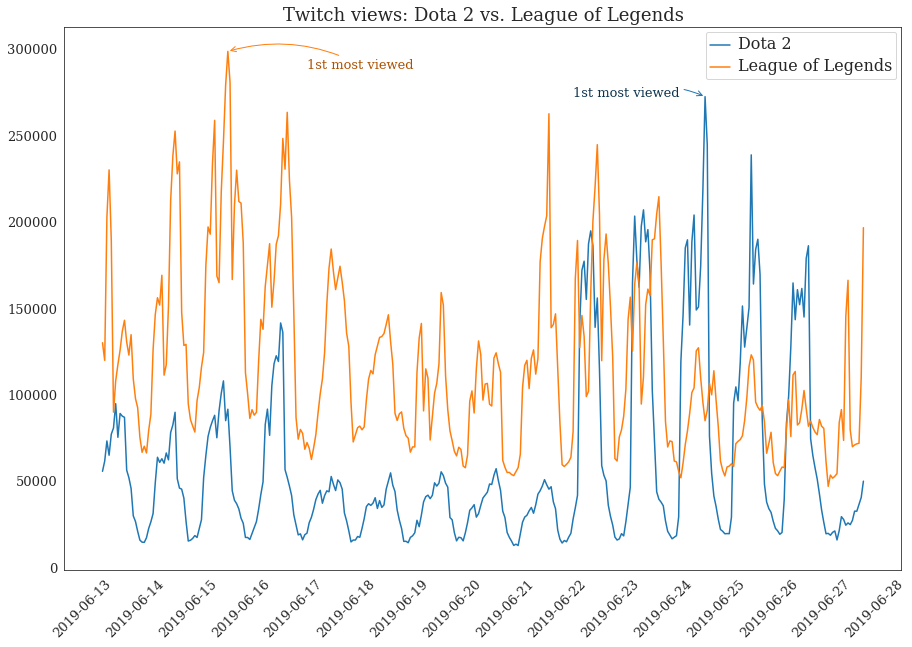

In [49]:
plot_twitch([ "Dota 2",  "League of Legends"], dfh, how = 'hourly', rad = ['-0.2', '0.2'],
           text_coors = [[-2.5, 0], [+1.5, -10000] ])

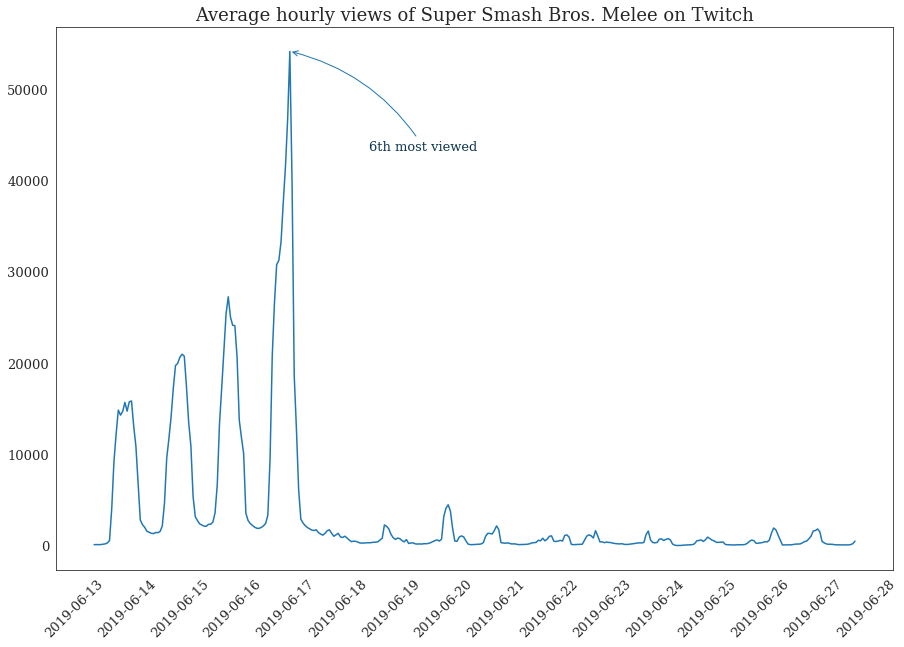

In [50]:
plot_twitch(["Super Smash Bros. Melee"], dfh, how = 'hourly')

# Twitter

### Get Data

In [25]:
pipeline_twit = [{"$group": {"_id": {"name": "$query",
                                     "day": { "$dayOfMonth": "$date" },
                                     "month": { "$month": "$date" },
                                     "year": { "$year": "$date" }},
                             "tot_retweets": { "$sum": "$retweets" },
                             "tot_likes": { "$sum" : "$likes"},
                             "tweet_count" : { "$sum": 1 }
                             }},
                 {"$sort": {"_id": 1} }]

In [26]:
result_twit = list(db.twitter.aggregate(pipeline_twit))

In [27]:
dft= json_normalize(result_twit)
dft= dft.rename(index=str, columns={"_id.name": "name", "_id.day": "day","_id.month": "month","_id.year": "year"})
dft= dft[['name', 'day', 'month', 'year', 'tot_retweets', 'tot_likes', 'tweet_count']]
dft.head()

,name,day,month,year,tot_retweets,tot_likes,tweet_count
0,apex legends,13,6,2019,54,349,96
1,apex legends,14,6,2019,140,1022,200
2,apex legends,15,6,2019,160,1154,200
3,apex legends,16,6,2019,173,1491,169
4,apex legends,17,6,2019,112,692,16


#### Add daily top

In [28]:
dft['daily_top'] = dft.sort_values(['day', 'month', 'year', 'tot_likes'], 
                                   ascending=[True, True, True, False]
                                  ).groupby(['day', 'month', 'year']).cumcount()
dft['daily_top'] = dft['daily_top'] + 1
dft.head()

,name,day,month,year,tot_retweets,tot_likes,tweet_count,daily_top
0,apex legends,13,6,2019,54,349,96,10
1,apex legends,14,6,2019,140,1022,200,12
2,apex legends,15,6,2019,160,1154,200,13
3,apex legends,16,6,2019,173,1491,169,9
4,apex legends,17,6,2019,112,692,16,27


## Viz Twitter

In [29]:
def add_text_tweet(i):
    i = str(i)
    suff = 'th'
    if i[-1] == '1' and i[-2:] != '11':
        suff = 'st'
    if i[-1] == '2' and i[-2:] != '12':
        suff = 'nd'
    if i[-1] == '3' and i[-2:] != '13':
        suff = 'rd'
    suff = suff + ' most liked'
    return(i+suff)

def plot_twitter_daily(gn, df):
    ogn = gn
    gn = gn.lower()
    gn_df = df[df.name == gn].sort_values('tot_likes', ascending = False)
    gn_df['day'] = gn_df['day'].astype(str)
    gn_df['month'] = gn_df['month'].astype(str)
    gn_df['year'] = gn_df['year'].astype(str)
    gn_df['date'] = gn_df['day'] + '-' + gn_df['month'] + '-' + gn_df['year']
    gn_df['date'] =  pd.to_datetime(gn_df['date'], format='%d-%m-%Y')
    
    # fill missing values between times
    gn_df.index = gn_df['date']
    gn_df = gn_df.resample('D', how='mean')
    gn_df['date'] = gn_df.index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    gn_df['tot_likes'] = gn_df['tot_likes'].fillna(0) # fill avgViewers NAs with 0
    
    # restore old index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    #gn_df['date'] = gn_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
    
    sns.set_style("white")
    # rcParams['font.family'] = 'garamond'
    # rcParams['font.family'] = 'helvetica'
    rcParams['font.family'] = 'serif'
    
    fig = plt.figure(figsize=(15, 10))
     
    ax = sns.lineplot(x="date", y="tot_likes", data=gn_df#, marker="o"
                     )
    
    ax.set_title("Daily total tweet likes for {} on Twitter".format(ogn), fontsize=18)
    
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=20)
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
    plt.xticks(rotation=45, fontsize = 13)
    plt.yticks(fontsize = 13)
    
    top = np.argmin(gn_df['daily_top'])
    top2 = np.argmax(gn_df['tot_likes'])
    
    ax.text(gn_df.date[top], gn_df.tot_likes[top],
        add_text_tweet(int(gn_df.daily_top[top])),
        horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    if int(top) not in range(int(top2)-10, int(top2)+10):
        ax.text(gn_df.date[top2], gn_df.tot_likes[top2],
                add_text_tweet(int(gn_df.daily_top[top2])),
                horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    plt.show()

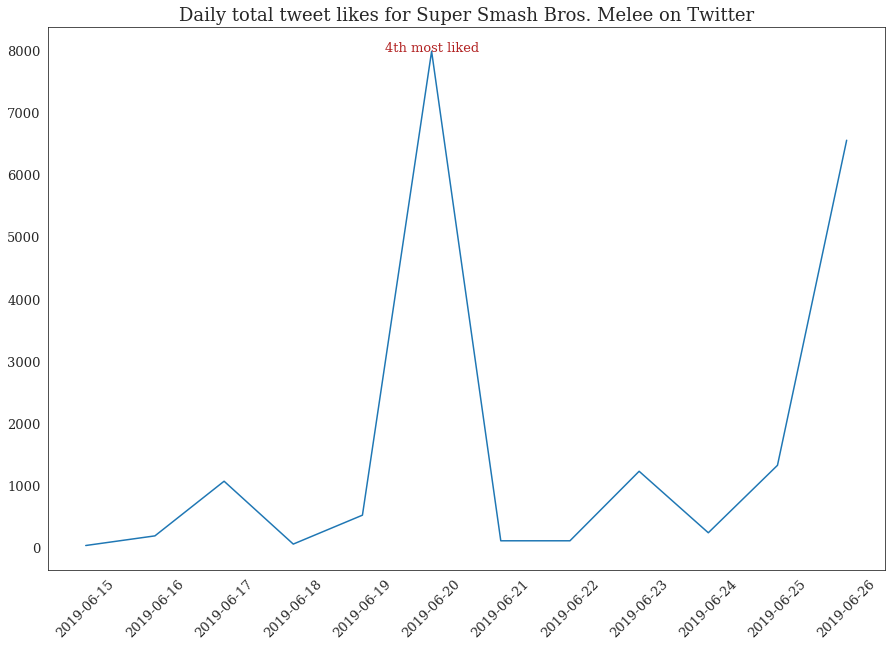

In [30]:
plot_twitter_daily('Super Smash Bros. Melee', dft)

# Close server

In [31]:
if server.is_active:
    server.stop()